# Regularized least squared problem with kernels with position and velocity as input

### import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn
plt.rcParams.update({
    'font.size': 12,           # Base font size
    'axes.titlesize': 16,      # Title font size
    'axes.labelsize': 14,      # Axis label font size
    'xtick.labelsize': 12,     # X-axis tick label size
    'ytick.labelsize': 12,     # Y-axis tick label size
    'legend.fontsize': 12,     # Legend font size
})

### Generating a random dataset

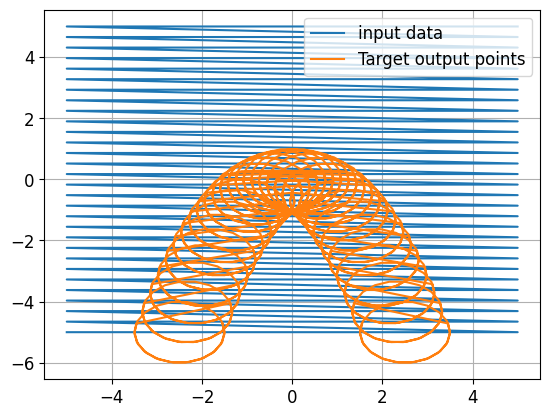

In [2]:
# Generate structured input data
x1 = np.linspace(-5, 5, 30)  # 1D input along first dimension
x2 = np.linspace(-5, 5, 30)  # 1D input along second dimension
x1, x2 = np.meshgrid(x1, x2)  # Create a 2D grid
input_data = np.column_stack((x1.ravel(), x2.ravel()))  # Flatten grid into pairs of (x1, x2)

# Define target outputs as interpretable functions of the inputs
def simple_target_function(x):
    y1 = np.sin(x[0]) + 0.5 * x[1]  # Combination of sine and linear terms
    y2 = np.cos(x[0]) - 0.2 * x[1]**2  # Combination of cosine and quadratic terms
    return np.array([y1, y2])

# Apply the function to each input point
target_outputs = np.array([simple_target_function(x) for x in input_data])

plt.plot(input_data[:,0], input_data[:,1], label = "input data")
plt.plot(target_outputs[:,0], target_outputs[:,1], label = "Target output points")
plt.grid()
plt.legend()
plt.savefig("testing_vector_valued_input.png")
plt.show()

### Computing the gassian kernel matrix

In [3]:
sigma, lam = [5, 0.0001]
def rbf_kernel(x, y, sigma):
    d = len(x)  # Number of coordinates (dimensionality)
    rbf = np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))
    I = np.eye(d)
        
    kernel_matrix = rbf * I
    return kernel_matrix

def gram_matrix(input_data, sigma):
    N, d = input_data.shape  # Number of data points, dimensionality
    K = np.zeros((N * d, N * d))  # Initialize Gram matrix

    for i in range(N):
        for j in range(N):
            # Compute vector-valued kernel matrix for pair (x_i, x_j)
            kernel_block = rbf_kernel(input_data[i], input_data[j], sigma)
            
            # Place the kernel block in the appropriate location in the Gram matrix
            K[i*d:(i+1)*d, j*d:(j+1)*d] = kernel_block

    return K
K = gram_matrix(input_data, sigma)


### Solve the minimization problem to obtain dual coefficients $a$

In [4]:
def dual_coeff(K, y, lambd):
    n = K.shape[0]  # Size of the Gram matrix (N*d)
    
    # Regularized Gram matrix
    K_reg = K + lambd * np.eye(n)
    
    # Solve for alpha
    alpha = np.linalg.solve(K_reg, y)
    return alpha
alpha = dual_coeff(K, target_outputs.flatten(), lam)

### Estimate the function based on $a$ and kernel matrix

In [5]:
def learned_outputs(input_data, alpha, sigma):
    
    num_datapoints, num_states = input_data.shape
    f = np.zeros((num_datapoints, num_states))  # Initialize output

    # Loop through each data point pair
    for i in range(num_datapoints):
        for j in range(num_datapoints):
            # Compute vector-valued kernel (matrix for the pair)
            kernel_matrix = rbf_kernel(input_data[i], input_data[j], sigma)
            
            # Extract alpha for data point j (size num_states)
            alpha_j = alpha[j * num_states:(j + 1) * num_states]
            
            # Add contribution to output f[i]
            f[i] += kernel_matrix @ alpha_j  # Matrix-vector multiplication

    return f
# Compute learned outputs
f = learned_outputs(input_data, alpha, sigma)

### Solve learned outputs to get trajectories

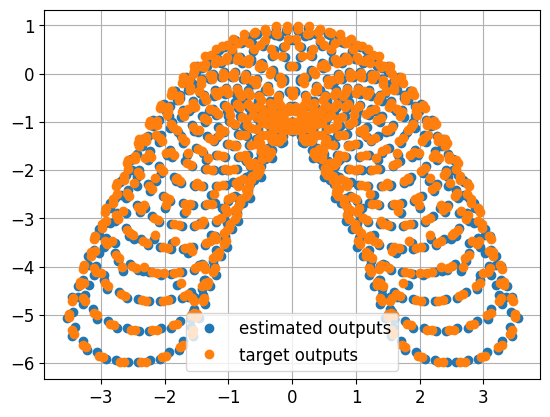

In [6]:
plt.plot(f[:,0], f[:,1], 'o', label="estimated outputs")
plt.plot(target_outputs[:,0], target_outputs[:,1], 'o', label = "target outputs")
plt.legend()
plt.grid()
plt.savefig("testing_vector_valued_outputs.png")
plt.show()